# MNIST XCNN with gradient ascent and feature maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model
import tensorflow as tf
import random

/Users/kesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Load and preprocess the MNIST dataset. (build a binary classifier for 8 and not 8)

In [2]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Modify labels: 8s are labeled as 1, non-8s are labeled as 0
y_train_binary = np.where(y_train == 8, 1, 0)
y_test_binary = np.where(y_test == 8, 1, 0)

# Preprocess the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# Split the dataset into training and validation sets
X_train, X_val, y_train_binary, y_val_binary = train_test_split(X_train, y_train_binary, test_size=0.2, random_state=42)

We will define a simple CNN ending with a 1x1x50 convolution passed to a FC layer

In [8]:
# Define the input layer
input_layer = Input(shape=(28, 28, 1))

#pool the input layer
# pool1 = MaxPooling2D(pool_size=(3, 3))(input_layer)
# # Convolutional layers
# conv1 = Conv2D(1, (28, 28), padding='same', activation='relu')(pool1)
# #conv2 = Conv2D(5, (1, 1), activation='relu')(conv1)
# conv3 = Conv2D(1, (28, 28), activation='relu')(conv1)

# # Flatten the output for the fully connected layer
# flatten = Flatten()(conv1)

# # Fully connected and output layers
# output_layer = Dense(1, activation='sigmoid')(flatten)

# Create the model
#model = Model(inputs=input_layer, outputs=output_layer)

model = Sequential(
    [
        Input(shape=(28, 28, 1)),
        #convolution layer with filter size as the pooled image size
        Conv2D(1, (20, 20), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3)),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)
# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the pre-trained model or train it
try:
    model = tf.keras.models.load_model('model/cifar-10.h5')
except:
    history = model.fit(X_train, y_train_binary, epochs=5, batch_size=64, validation_data=(X_val, y_val_binary))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test_binary)
    test_f1 = 2 * (test_acc * test_acc) / (test_acc + test_acc)
    print(f'Test accuracy: {test_acc}')
    print(f'Test f1 macro: {test_f1}')

    # Save the trained model
    model.save('model/xcnn.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 9, 9, 1)           401       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 1)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 


Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
for layer in model.layers:
    print(layer.name)


conv2d_3
max_pooling2d_2
conv2d_4
max_pooling2d_3
conv2d_5


A few helper functions

In [10]:
def get_submodel(model, layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

In [11]:
def create_image():
  return tf.random.uniform((28,28, 1), minval = -0.5, maxval = 0.5)

#plots the image
def plot_image(image, title = 'random'):
  image = image - tf.math.reduce_min(image)
  image = image / tf.math.reduce_max(image)
  plt.imshow(image, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

#gradient ascent for maximising the given filter's output
def visualise_filters(model, layer_name, f_index = None, iters = 20):
  submodel = get_submodel(model, layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters - 1)

  assert num_filters > f_index, 'filter index out of bounds'

  image = create_image()
  verbose_step = int(iters / 5)

  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      out = submodel(tf.expand_dims(image, axis = 0))[:, :, :, f_index]
      loss = tf.math.reduce_mean(out)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += grads * 10

  
  if (i + 1) % verbose_step == 0:
      print(f'Iteration: {i + 1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')

Let's perform activation mapping for a particular image (using a positive class example for starters)

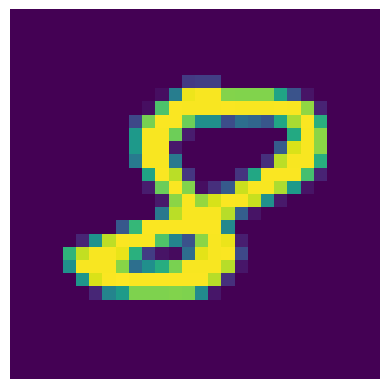

ValueError: in user code:

    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/kesh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 1)


In [14]:
#positive class at 61
image = X_test[61]

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Make the model predict on the image
prediction = model.predict(image, verbose = 0)
print(f'Probability that the given image is 8 : {prediction[0][0]}')


In [ ]:
#getting the weights of the last layer
weights_FC = model.layers[-1].get_weights()[0]


#getting the output of the last convolutional layer
model_penultimate = get_submodel(model, model.layers[-2].name)

print("layer name: ", model.layers[-2].name)
#obtain the output of the last convolutional layer
activations_penultimate = model_penultimate.predict(image.reshape(1, 28, 28, 1), verbose = 0)

print(list(zip(list(range(len(activations_penultimate[0]))), activations_penultimate[0])))

layer name:  flatten_18
[(0, 3.6155412), (1, 0.0060532093), (2, 0.64152986), (3, 0.6617465), (4, 0.96443653), (5, 8.091389), (6, 0.0), (7, 0.2585715), (8, 4.9589787)]


In [ ]:
#defning a threshold value, if it's greater then the corresponding filter must be bright for the output
threshold = -10

#obtaining the dot product of the weights and the activations
dot_product = np.multiply(weights_FC[0], activations_penultimate[0])

print(dot_product)
#store the indices of the filters that are bright
indices = np.where(dot_product > threshold)[0]

print(indices)

[[[-9.94088948e-02]
  [-5.71427606e-02]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-2.03764215e-02]
  [-8.91887397e-02]
  [-1.19210064e-01]
  [-6.12781793e-02]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-1.67222861e-02]
  [-3.54329236e-02]
  [-2.81911660e-02]
  [-4.89406623e-02]
  [-6.45372644e-02]
  [-6.49009570e-02]
  [-2.70014871e-02]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-2.56431159e-02]]

 [[-7.78725818e-02]
  [-5.26927300e-02]
  [-2.69914482e-04]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-2.70923786e-03]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-0.00000000e+00]
  [-3.33173797e-02]
  [-8.04557204e-02]
  [-1.05034910e-01]
  [-1.01498321e-01

Iteration: 20, Loss: 34.9587


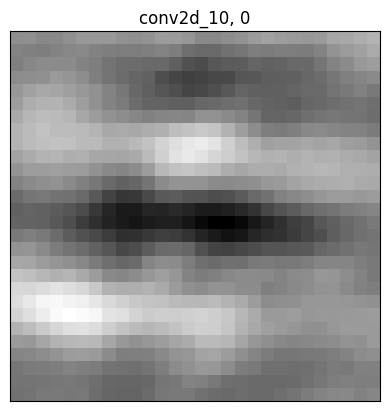

Iteration: 20, Loss: 30.8707


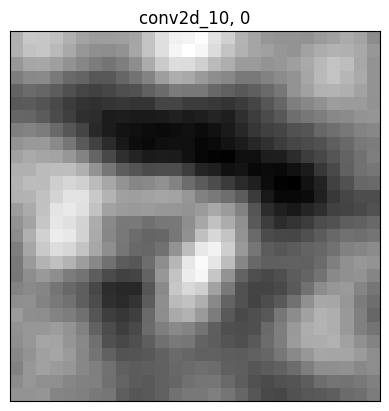

Iteration: 20, Loss: 32.0527


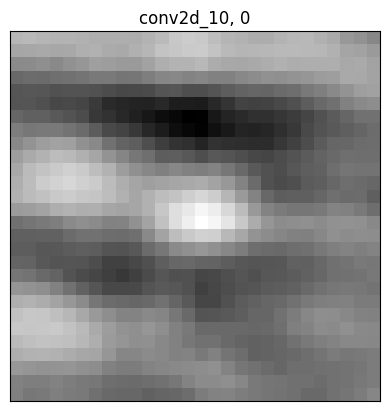

Iteration: 20, Loss: 35.9202


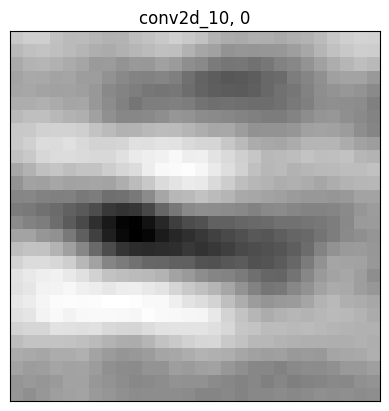

Iteration: 20, Loss: 31.7313


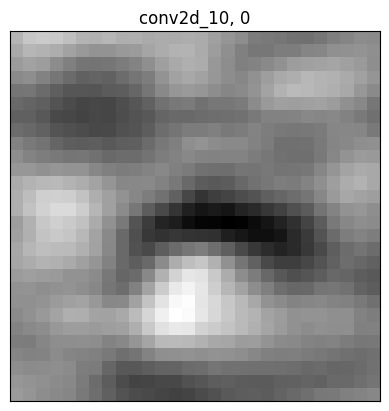

Iteration: 20, Loss: 33.1344


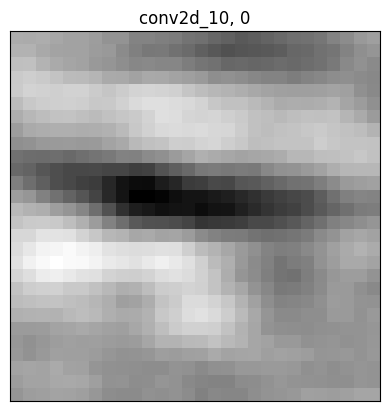

Iteration: 20, Loss: 30.4825


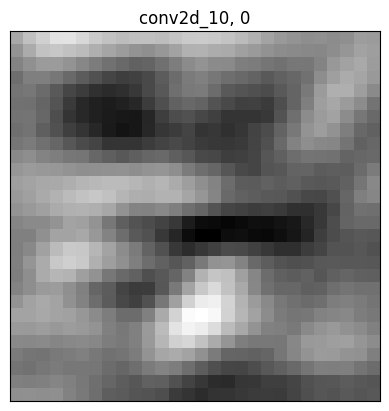

Iteration: 20, Loss: 32.5702


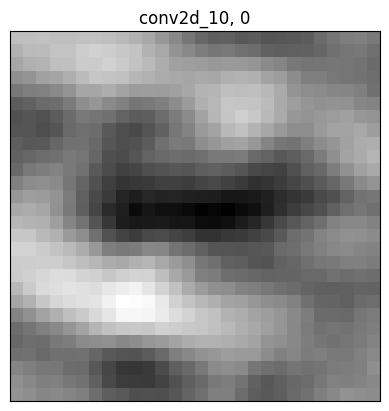

Iteration: 20, Loss: 33.0312


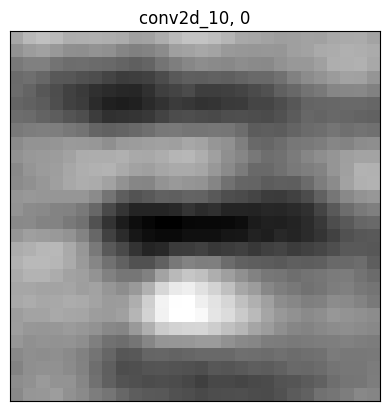

Iteration: 20, Loss: 36.4615


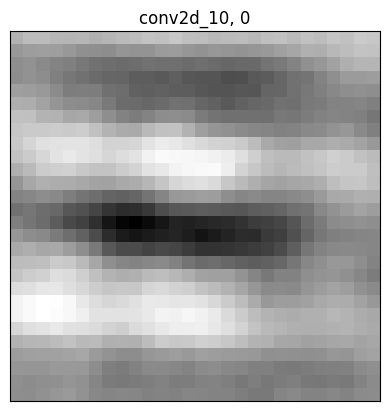

Iteration: 20, Loss: 32.0898


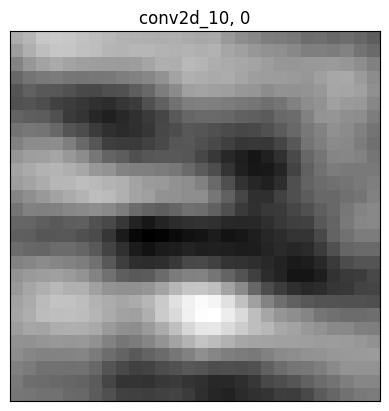

Iteration: 20, Loss: 34.2831


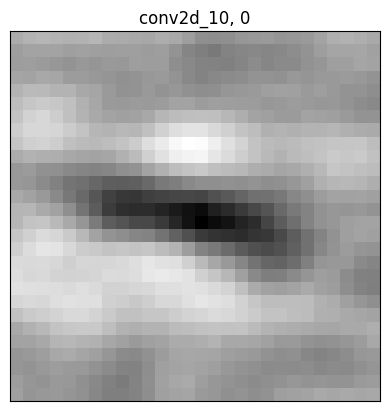

Iteration: 20, Loss: 35.4746


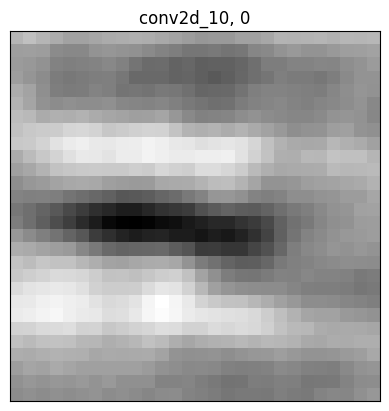

Iteration: 20, Loss: 34.0323


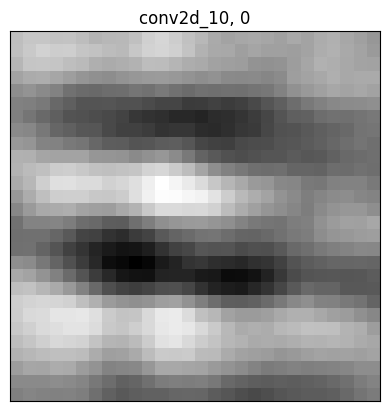

Iteration: 20, Loss: 31.2247


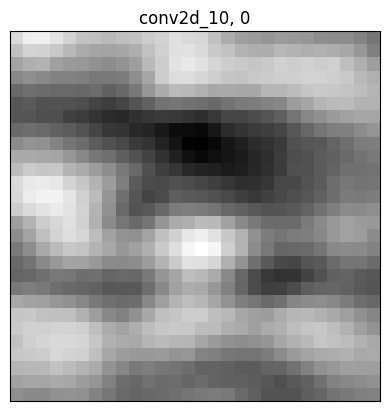

Iteration: 20, Loss: 31.0611


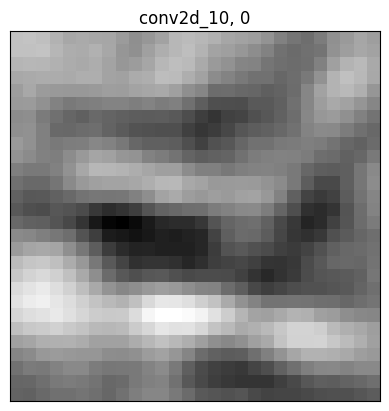

Iteration: 20, Loss: 28.2523


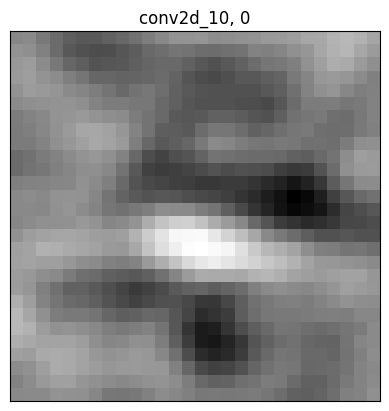

Iteration: 20, Loss: 33.1622


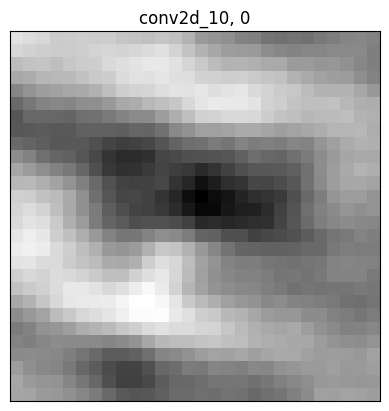

Iteration: 20, Loss: 31.6164


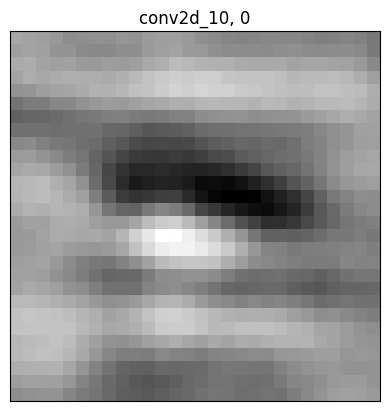

Iteration: 20, Loss: 33.2755


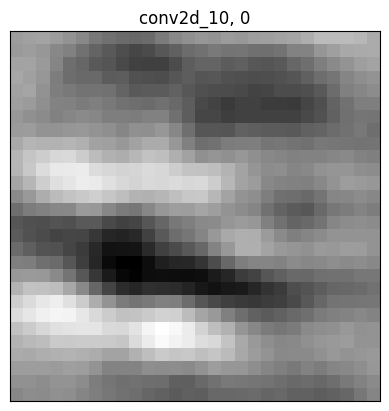

Iteration: 20, Loss: 31.2901


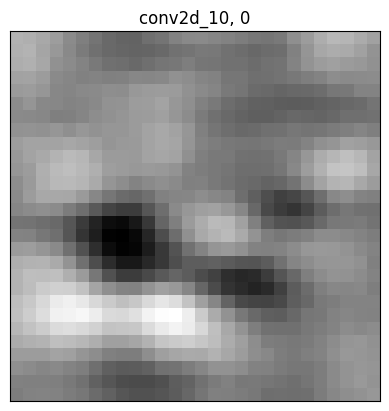

Iteration: 20, Loss: 31.3313


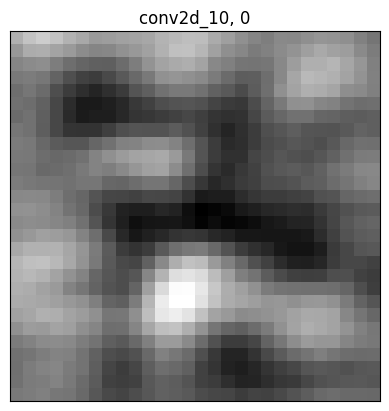

Iteration: 20, Loss: 35.9203


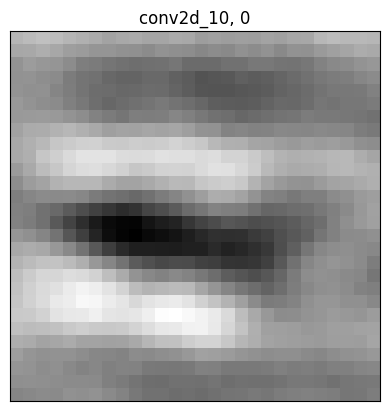

Iteration: 20, Loss: 32.4468


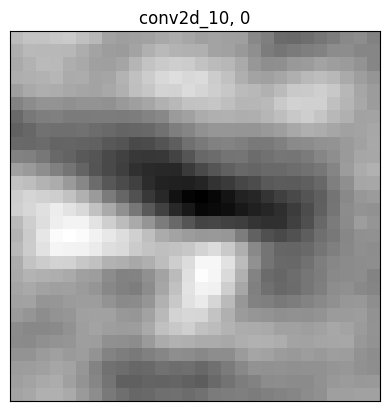

Iteration: 20, Loss: 31.4161


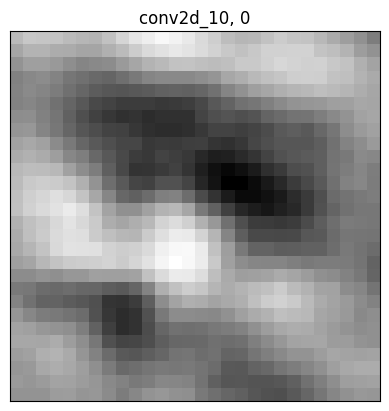

Iteration: 20, Loss: 31.0687


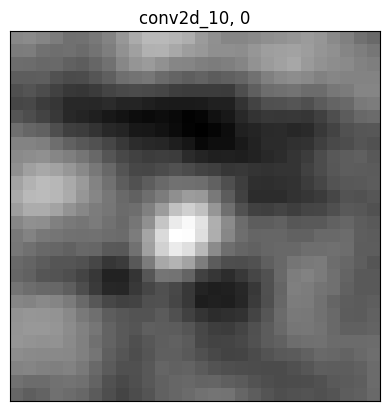

Iteration: 20, Loss: 35.6539


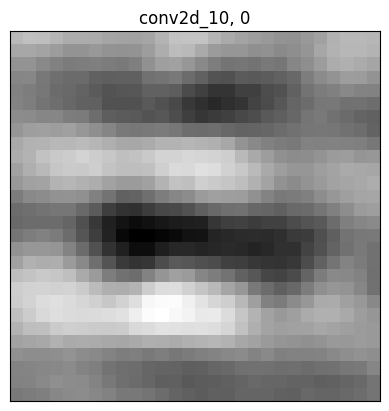

Iteration: 20, Loss: 31.6174


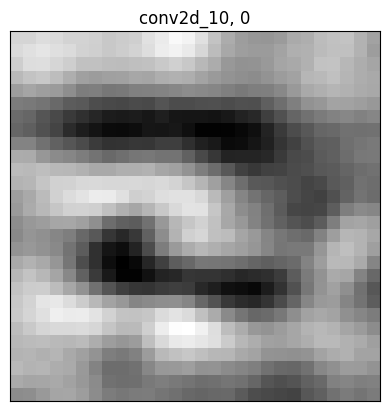

AssertionError: filter index out of bounds

In [ ]:
#iterate over the indices and gradient ascent to obtain the images that maximize the output of the filters
for i in indices:
    visualise_filters(model = model, layer_name = model.layers[-3].name , f_index = i)